In [43]:
import pandas as pd


data = pd.read_excel("GAIA IA v.1.3.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [44]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(5):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0

In [45]:
y = data[['Al2O3.5', 'Fe2O3.5', 'CS-C.5', 'Carbono.5']]
X = data.drop(columns=['Al2O3.5', 'Fe2O3.5', 'CS-C.5', 'Carbono.5'])
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 4), dtype=torch.float32) #1 ->4
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 4), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(55, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 4)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 150
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")

Epoch 1/150, Loss: 192.2379
Epoch 2/150, Loss: 186.5662
Epoch 3/150, Loss: 178.5572
Epoch 4/150, Loss: 165.2648
Epoch 5/150, Loss: 145.6051
Epoch 6/150, Loss: 118.4498
Epoch 7/150, Loss: 84.8398
Epoch 8/150, Loss: 51.1489
Epoch 9/150, Loss: 28.3454
Epoch 10/150, Loss: 17.0942
Epoch 11/150, Loss: 12.5724
Epoch 12/150, Loss: 10.0182
Epoch 13/150, Loss: 7.4626
Epoch 14/150, Loss: 5.3907
Epoch 15/150, Loss: 4.4969
Epoch 16/150, Loss: 4.1242
Epoch 17/150, Loss: 3.5945
Epoch 18/150, Loss: 3.1241
Epoch 19/150, Loss: 2.9510
Epoch 20/150, Loss: 2.6391
Epoch 21/150, Loss: 2.4559
Epoch 22/150, Loss: 2.3215
Epoch 23/150, Loss: 2.1569
Epoch 24/150, Loss: 1.9882
Epoch 25/150, Loss: 1.8673
Epoch 26/150, Loss: 1.7207
Epoch 27/150, Loss: 1.6344
Epoch 28/150, Loss: 1.5198
Epoch 29/150, Loss: 1.4412
Epoch 30/150, Loss: 1.3785
Epoch 31/150, Loss: 1.3522
Epoch 32/150, Loss: 1.2510
Epoch 33/150, Loss: 1.1638
Epoch 34/150, Loss: 1.1050
Epoch 35/150, Loss: 1.0535
Epoch 36/150, Loss: 1.0184
Epoch 37/150, Loss:

In [47]:

def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

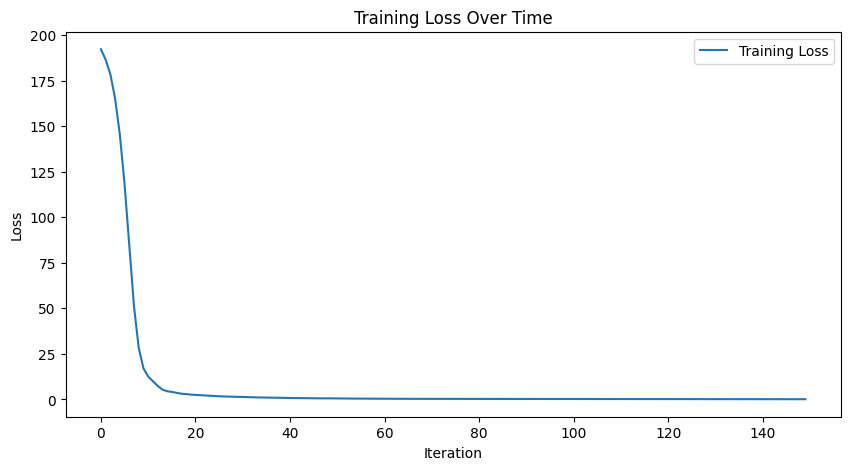

In [48]:
plot_loss()

In [49]:
def plot_compare():
    target_names = ['Al2O3', 'Fe2O3', 'CS-C', 'Carbono']

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):
        actual = y_test_tensor[:, i].numpy()
        pred = predictions[:, i].numpy()
        ax.plot(actual, label='Actual', color='blue')
        ax.plot(pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{target_names[i]}: Actual vs Predicted')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel(target_names[i])
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

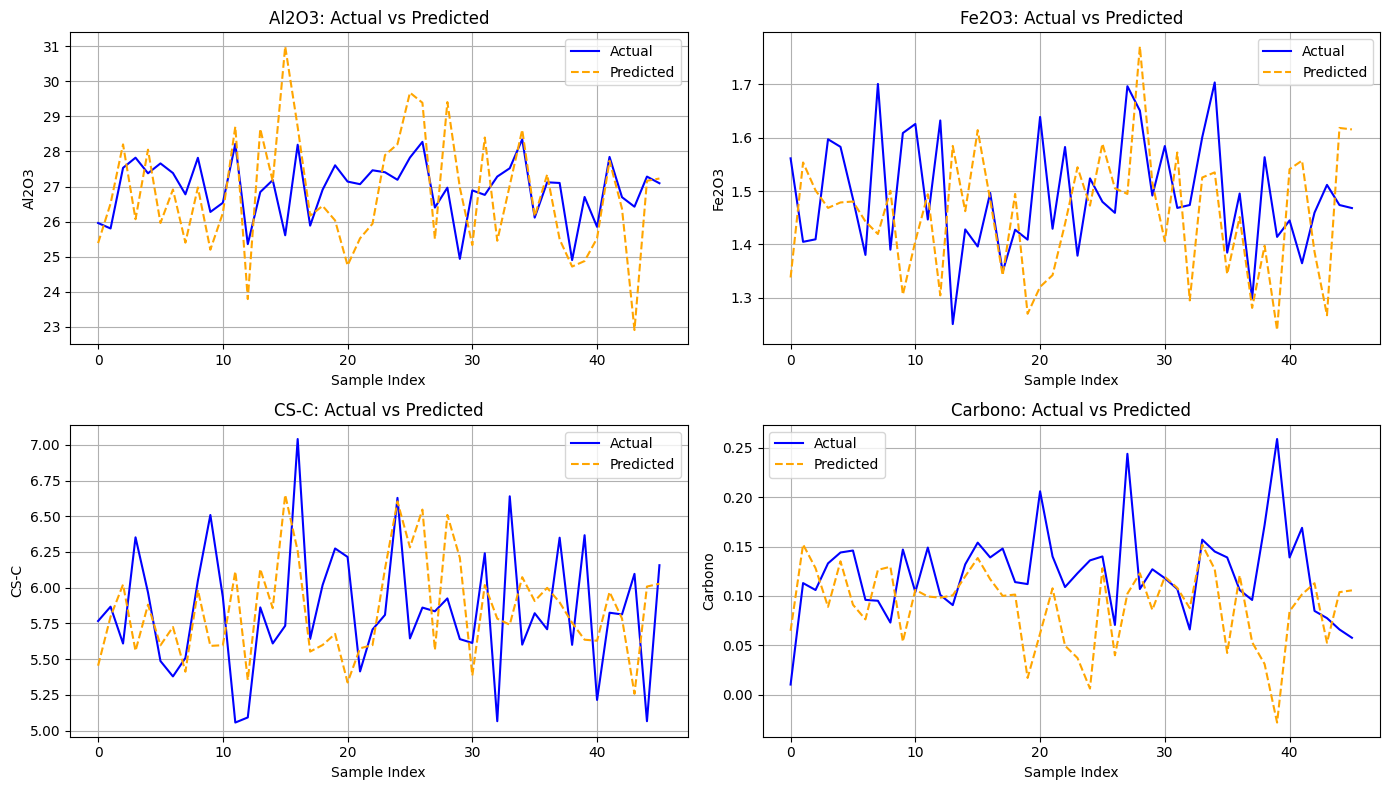

In [50]:
plot_compare()

In [51]:
def evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=5):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
        mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()
        

    y_true = y_test_tensor.numpy().flatten()
    y_pred = predictions.numpy().flatten()

    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': y_pred - y_true
    })

    print(f"Evaluation Results:\n - MSE: {mse:.4f}\n - MAE: {mae:.4f} \n - R2: {r2.item():.4f}")
    print("\nExample predictions:")
    print(results_df.head(n))

    return results_df

In [52]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10)

Evaluation Results:
 - MSE: 0.6408
 - MAE: 0.4314 
 - R2: 0.9945

Example predictions:
      Actual  Predicted     Error
0  25.960688  25.387871 -0.572817
1   1.561302   1.337708 -0.223595
2   5.767001   5.454505 -0.312496
3   0.010200   0.064670  0.054470
4  25.805275  26.515766  0.710491
5   1.404642   1.553578  0.148936
6   5.867491   5.797823 -0.069667
7   0.113000   0.152186  0.039186
8  27.533176  28.202778  0.669601
9   1.409339   1.501185  0.091846


In [53]:
y = data[['Al2O3.5', 'Fe2O3.5','Carbono.5']]
X = data.filter(regex='^Al2O3|^Fe2O3|^Carbono|^%')
X = X.drop(columns=['Al2O3.5', 'Fe2O3.5', 'Carbono.5'])

In [54]:
X.shape, y.shape

((230, 20), (230, 3))

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 3), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 3), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 3)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")

Epoch 1/200, Loss: 244.1209
Epoch 2/200, Loss: 241.2895
Epoch 3/200, Loss: 237.6376
Epoch 4/200, Loss: 233.4265
Epoch 5/200, Loss: 227.3589
Epoch 6/200, Loss: 220.1334
Epoch 7/200, Loss: 210.6447
Epoch 8/200, Loss: 198.9932
Epoch 9/200, Loss: 185.3545
Epoch 10/200, Loss: 168.7534
Epoch 11/200, Loss: 149.3912
Epoch 12/200, Loss: 126.8148
Epoch 13/200, Loss: 103.1457
Epoch 14/200, Loss: 79.8057
Epoch 15/200, Loss: 57.2981
Epoch 16/200, Loss: 39.2021
Epoch 17/200, Loss: 25.5229
Epoch 18/200, Loss: 17.4787
Epoch 19/200, Loss: 14.1279
Epoch 20/200, Loss: 12.5367
Epoch 21/200, Loss: 11.2780
Epoch 22/200, Loss: 10.0842
Epoch 23/200, Loss: 9.2451
Epoch 24/200, Loss: 8.1434
Epoch 25/200, Loss: 7.8394
Epoch 26/200, Loss: 7.1454
Epoch 27/200, Loss: 6.6334
Epoch 28/200, Loss: 6.2721
Epoch 29/200, Loss: 5.9769
Epoch 30/200, Loss: 5.5532
Epoch 31/200, Loss: 5.3833
Epoch 32/200, Loss: 5.0617
Epoch 33/200, Loss: 4.8903
Epoch 34/200, Loss: 4.5841
Epoch 35/200, Loss: 4.4135
Epoch 36/200, Loss: 4.1083
Ep

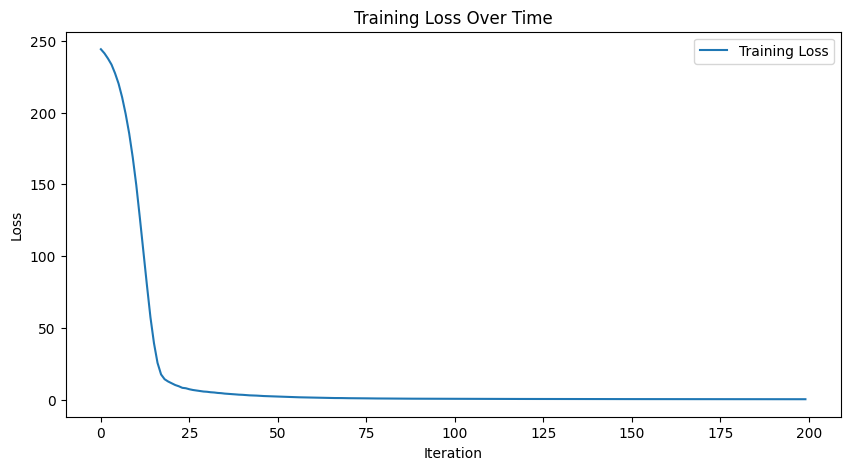

In [67]:
plot_loss()

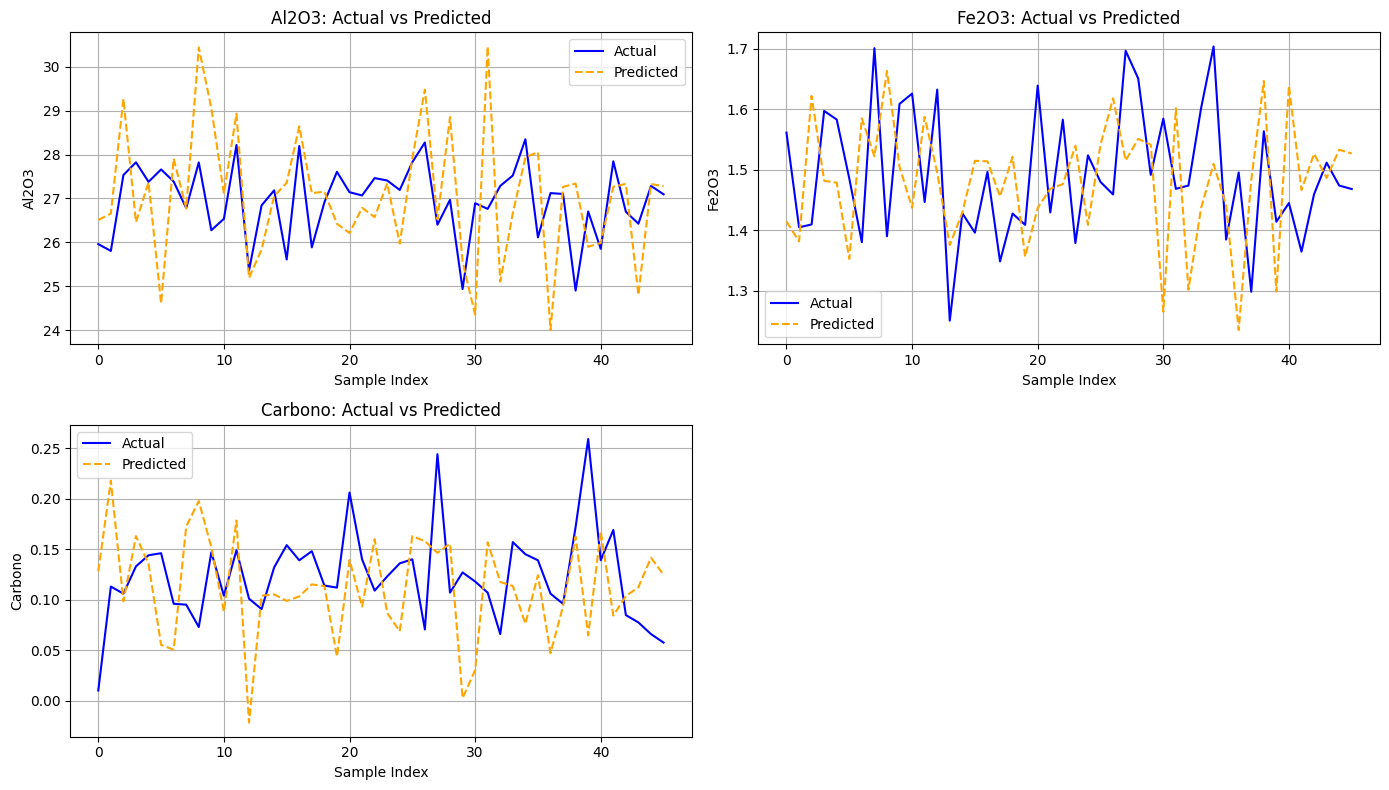

In [68]:
target_names = ['Al2O3', 'Fe2O3','Carbono']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, ax in enumerate(axs.ravel()):
    if i >= len(target_names):
        break
    actual = y_test_tensor[:, i].numpy()
    pred = predictions[:, i].numpy()
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', linestyle='--', color='orange')
    ax.set_title(f'{target_names[i]}: Actual vs Predicted')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(target_names[i])
    ax.grid(True)
    ax.legend()


for i in range(len(target_names), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])
plt.tight_layout()
plt.show()

In [69]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10)

Evaluation Results:
 - MSE: 0.7044
 - MAE: 0.4200 
 - R2: 0.9954

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.508980  0.548292
1   1.561302   1.414298 -0.147005
2   0.010200   0.128012  0.117812
3  25.805275  26.658247  0.852972
4   1.404642   1.381372 -0.023270
5   0.113000   0.217756  0.104756
6  27.533176  29.267967  1.734791
7   1.409339   1.621943  0.212604
8   0.106000   0.098503 -0.007497
9  27.822983  26.459366 -1.363617
